<a href="https://colab.research.google.com/github/RonneyPetras/ifood-data-analysis-case/blob/main/03_segmentation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentções

### Importando blibiotecas

In [13]:
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu, shapiro
import numpy as np

### Montando o Gdrive, altere o caminho se necessário

In [14]:
caminho_gdrive = "/content/drive/MyDrive/ifood_case/ifood-data" # @param {"type":"string"}

In [15]:
drive.mount('/content/drive')

# Define caminho (substitua SEU_DIRETORIO pelo nome da pasta que você quer usar)
os.makedirs(caminho_gdrive, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analisando segmentações

* Segmento por Valor Gasto (Baixo/Médio/Alto):
* Segmento por Frequência (Ocasional/Frequente):
* Segmento por Localização (Exemplo: São Paulo vs Outros):

### Importação da base e merge

In [16]:
df_pedidos = pd.read_parquet(caminho_gdrive+'/df_expurgado.parquet')
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3597571 entries, 0 to 3670825
Data columns (total 5 columns):
 #   Column              Dtype  
---  ------              -----  
 0   order_id            object 
 1   customer_id         object 
 2   order_total_amount  float64
 3   merchant_id         object 
 4   is_target           object 
dtypes: float64(1), object(4)
memory usage: 164.7+ MB


In [17]:
df_consumer = pd.read_csv(caminho_gdrive+'/consumer.csv')
df_consumer = df_consumer[['customer_id', 'active', 'customer_phone_area']]
df_consumer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806156 entries, 0 to 806155
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   customer_id          806156 non-null  object
 1   active               806156 non-null  bool  
 2   customer_phone_area  806156 non-null  int64 
dtypes: bool(1), int64(1), object(1)
memory usage: 13.1+ MB


In [18]:
df_restaurant = pd.read_csv(caminho_gdrive+'/restaurant.csv')
df_restaurant = df_restaurant[['id', 'merchant_city', 'merchant_state']]
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7292 entries, 0 to 7291
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7292 non-null   object
 1   merchant_city   7292 non-null   object
 2   merchant_state  7292 non-null   object
dtypes: object(3)
memory usage: 171.0+ KB


In [19]:
df_merged = pd.merge(df_pedidos, df_consumer, on='customer_id')
df_merged = pd.merge(df_merged, df_restaurant, left_on='merchant_id', right_on='id')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588508 entries, 0 to 3588507
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   order_id             object 
 1   customer_id          object 
 2   order_total_amount   float64
 3   merchant_id          object 
 4   is_target            object 
 5   active               bool   
 6   customer_phone_area  int64  
 7   id                   object 
 8   merchant_city        object 
 9   merchant_state       object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 249.8+ MB


#### Segmentação por faixa de preço

In [20]:
# Calcular gasto médio por usuário
df_faixa_preco = df_merged.groupby('customer_id')['order_total_amount'].sum().reset_index()
df_faixa_preco['segment'] = pd.qcut(df_faixa_preco['order_total_amount'], q=3, labels=['baixo', 'médio', 'alto'])

In [21]:
# calcular os indicadores para os segumentos
def calcula_indicadores(segment_name, segment_df):
    # Juntar com dados do A/B Test
    segment_ab = pd.merge(segment_df, df_merged[['customer_id', 'is_target']], on='customer_id')

    # Métricas por grupo (target vs controle)
    indicadores = segment_ab.groupby(['segment', 'is_target'], observed=False).agg(
        qtd=('customer_id', 'nunique'),
        ticket_medio=('order_total_amount', 'mean'),
        total=('order_total_amount', 'sum')
    ).reset_index()

    return indicadores

In [22]:
indicadores_segmentado = calcula_indicadores('valor_gasto', df_faixa_preco)

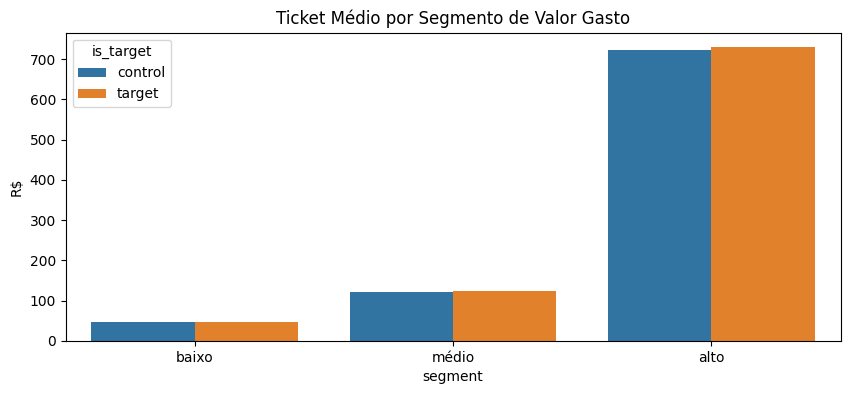

  segment is_target     qtd  ticket_medio         total
0   baixo   control  129677     45.980196  8.596320e+06
1   baixo    target  136273     46.744799  9.479097e+06
2   médio   control  118541    120.782720  3.867970e+07
3   médio    target  147423    122.765439  5.232165e+07
4    alto   control  108160    722.519410  7.138412e+08
5    alto    target  157771    729.399270  1.068091e+09


In [23]:
plt.figure(figsize=(10, 4))
sns.barplot(x='segment', y='ticket_medio', hue='is_target', data=indicadores_segmentado)
plt.title('Ticket Médio por Segmento de Valor Gasto')
plt.ylabel('R$')
plt.show()
print(indicadores_segmentado)

#### Segmentação por frequencia de pedidos

In [25]:
df_frequencia_pedidos = df_merged.groupby('customer_id')['order_id'].count().reset_index()
df_frequencia_pedidos['segment'] = np.where(df_frequencia_pedidos['order_id'] > df_frequencia_pedidos['order_id'].median(), 'frequente', 'ocasional')
df_frequencia_pedidos = pd.merge(df_frequencia_pedidos, df_merged[['customer_id', 'order_total_amount']], on='customer_id', how='left')

In [26]:
indicadores_segmentado = calcula_indicadores('valor_gasto', df_frequencia_pedidos)

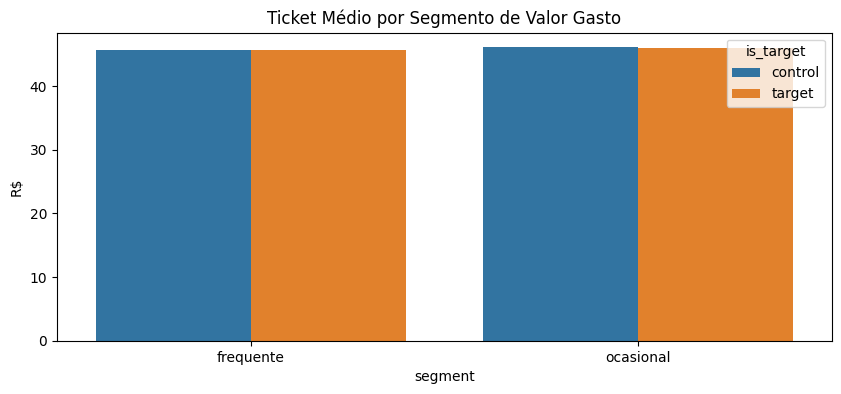

     segment is_target     qtd  ticket_medio         total
0  frequente   control  151594     45.620961  7.358633e+08
1  frequente    target  226786     45.694277  1.102953e+09
2  ocasional   control  204784     46.090463  2.525393e+07
3  ocasional    target  214681     46.049109  2.693905e+07


In [27]:
plt.figure(figsize=(10, 4))
sns.barplot(x='segment', y='ticket_medio', hue='is_target', data=indicadores_segmentado)
plt.title('Ticket Médio por Segmento de Valor Gasto')
plt.ylabel('R$')
plt.show()
print(indicadores_segmentado)

In [28]:
df_merged.columns

Index(['order_id', 'customer_id', 'order_total_amount', 'merchant_id',
       'is_target', 'active', 'customer_phone_area', 'id', 'merchant_city',
       'merchant_state'],
      dtype='object')

In [31]:
top_cidades = ['SAO PAULO', 'RIO DE JANEIRO', 'BELO HORIZONTE', 'FORTALEZA', 'RECIFE', 'BRASILIA']

df_segmento_cidade = df_merged[['order_id', 'customer_id', 'merchant_city', 'order_total_amount']].copy()

df_segmento_cidade['segment'] = df_segmento_cidade['merchant_city'].apply(
    lambda x: x if x in top_cidades else 'Outros'
)

In [ ]:
indicadores_segmentado = calcula_indicadores('valor_gasto', df_segmento_cidade)
indicadores_segmentado

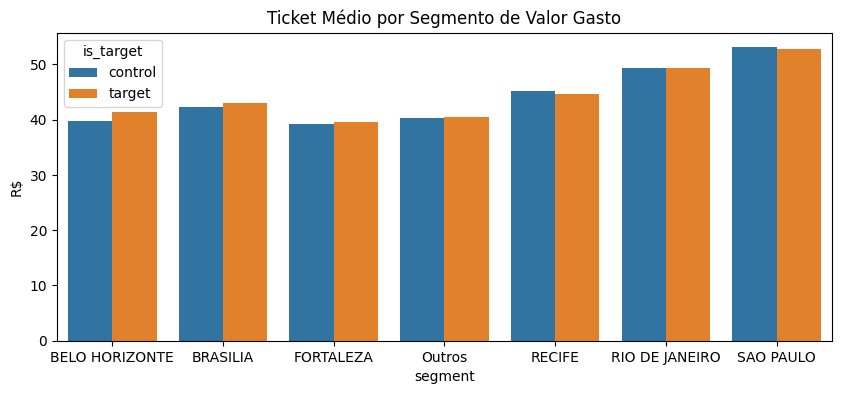

In [33]:
plt.figure(figsize=(10, 4))
sns.barplot(x='segment', y='ticket_medio', hue='is_target', data=indicadores_segmentado)
plt.title('Ticket Médio por Segmento de Valor Gasto')
plt.ylabel('R$')
plt.show()